### IMPORTS AND LIBRARIES

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import nltk
import re
import string
import contractions
import inflect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


### NLTK RESOURCES

In [58]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asuar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asuar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asuar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Cargar nuevos datos etiquetados y formatear (JD)

### Cargar noticias y datos etiquetados a DF

In [ ]:
# --------------------------------------------------------
# Noticias a evaluar
# --------------------------------------------------------

# Estructura del CSV esperada:
# ┌──────────────┬─────────────────┬─────────────────────┬────────────┐
# │   url        │     fecha       |       titulo        │  texto     │
# └──────────────┴─────────────────┴─────────────────────┴────────────┘
# label: (opcional para evaluación) - valores posibles: "izquierda", "centro", "derecha"

df = pd.read_csv(r"../noticias_completas_final.csv", sep="~") 
df = df.dropna(subset=['texto']) 

print(df.head())
print(df.columns)

# --------------------------------------------------------
# Noticias etiquetadas
# --------------------------------------------------------

# Estructura del CSV esperada:
# ┌──────────────┬─────────────────┬─────────────────────┬────────────┬────────────┐
# │   url        │     fecha       |       titulo        │  texto     │   etiqueta │
# └──────────────┴─────────────────┴─────────────────────┴────────────┴────────────┘
# label: (opcional para evaluación) - valores posibles: "izquierda", "centro", "derecha"

#df_et = pd.read_csv(r"../etiquetados2.csv", sep="~") 
df_et = pd.read_csv(r"../etiquetados2.csv", sep="~")
df_et = df_et.dropna(subset=['texto']) 

print("df etiquetado")
print(df_et.head())
df_et.rename(columns={"etiqueta;;;;;": "etiqueta"}, inplace=True)
print(df_et.columns)

print("\n")
# Asegúrate de que todo esté en minúsculas y sin espacios extras
df_et['etiqueta'] = df_et['etiqueta'].str.strip().str.lower()

# Reemplazar variantes por valores correctos
df_et['etiqueta'] = df_et['etiqueta'].replace({
    ' derecha': 'derecha',
    'derecha ': 'derecha',
    'izquierda,': 'izquierda',
    'izquierda,,,,,,,,,,,,,,,,,,,,,,,,,': 'izquierda'
})

# Corregir posibles otros errores con strip() y eliminar nulos
df_et['etiqueta'] = df_et['etiqueta'].str.strip()
df_et = df_et[df_et['etiqueta'].isin(['centro', 'izquierda', 'derecha'])]

# Verificar resultado
print(df_et['etiqueta'].unique())


                                                 url                fecha  \
0  https://www.eltiempo.com/economia/sectores/col...  2024-01-02 04:45:00   
1  https://www.eltiempo.com/economia/sectores/pea...  2024-01-02 04:45:00   
2  https://www.eltiempo.com/opinion/editorial/edi...  2024-01-02 02:45:00   
3  https://www.eltiempo.com/economia/sectores/fen...  2024-01-02 12:15:00   
4  https://www.eltiempo.com/vida/educacion/noveda...  2024-01-02 04:45:00   

                                              titulo  \
0  Colombianos tendrán un alivio en alzas que lle...   
1  Peajes y arriendos subirán en el 2024 con el d...   
2  Editorial de EL TIEMPO del 2 de enero de 2024 ...   
3  Fenalco sobre salario mínimo :  Es un alza par...   
4  Novedades del decreto sobre la gratuidad en la...   

                                               texto  
0   El arranque de un nuevo año suele verse empañ...  
1   Uno de los cobros que siguen atados a la infl...  
2  A dos días de terminar el año pa

### PREPROCESAMIENTO DE TEXTO

In [ ]:
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()
inflect_engine = inflect.engine()

# --------------------------------------------------------
# Noticias a evaluar
# --------------------------------------------------------
def preprocess_text(text):
    # Expandir contracciones
    text = contractions.fix(text)
    
    # Lowercase y eliminar puntuación
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenizar
    tokens = nltk.word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    
    return " ".join(tokens)

df['texto_limpio'] = df['texto'].apply(preprocess_text)

# --------------------------------------------------------
# Etiquetadas
# --------------------------------------------------------
def preprocess_text(text):
    # Expandir contracciones
    text = contractions.fix(text)
    
    # Lowercase y eliminar puntuación
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenizar
    tokens = nltk.word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    
    return " ".join(tokens)

df_et['texto_limpio'] = df_et['texto'].apply(preprocess_text)

### VECTORIZACION

In [61]:
# Entrenamos el vectorizador SOLO con los datos etiquetados
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_etiquetados = vectorizer.fit_transform(df_et['texto_limpio'])  # OK

# Las etiquetas (por ejemplo: 0=izquierda, 1=centro, 2=derecha)
y_etiquetas = df_et['etiqueta']  

### Entrenar el modelo supervisado

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_etiquetados, y_etiquetas, test_size=0.2, random_state=42, stratify=y_etiquetas)

# Entrenar modelo
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

# Evaluar
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      centro       0.95      0.80      0.87        25
     derecha       0.83      0.75      0.79        20
   izquierda       0.75      1.00      0.86        18

    accuracy                           0.84        63
   macro avg       0.85      0.85      0.84        63
weighted avg       0.86      0.84      0.84        63



### Guardar modelo entrenado

In [63]:
import joblib
joblib.dump(modelo, "modelo_ideologia.pkl")
joblib.dump(vectorizer, "vectorizer_tfidf.pkl")


['vectorizer_tfidf.pkl']

### Usar modelo en las noticias y visualizar resultado

                                               titulo prediccion_ideologia
0   Colombianos tendrán un alivio en alzas que lle...            izquierda
1   Peajes y arriendos subirán en el 2024 con el d...               centro
2   Editorial de EL TIEMPO del 2 de enero de 2024 ...               centro
3   Fenalco sobre salario mínimo :  Es un alza par...               centro
4   Novedades del decreto sobre la gratuidad en la...            izquierda
5   Editorial de EL TIEMPO del 2 de enero de 2024 ...               centro
6   Carlos Fernando Galán : Minuto a minuto de la ...               centro
7   Este es el incremento que tendrán las cuotas m...               centro
9   Brasil : Lula da Silva cumple un año de gobier...               centro
10  Antioquia : este es el gabinete de Andrés Juli...               centro


C:\Users\Asuar\AppData\Local\Temp\ipykernel_32336\2593291636.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


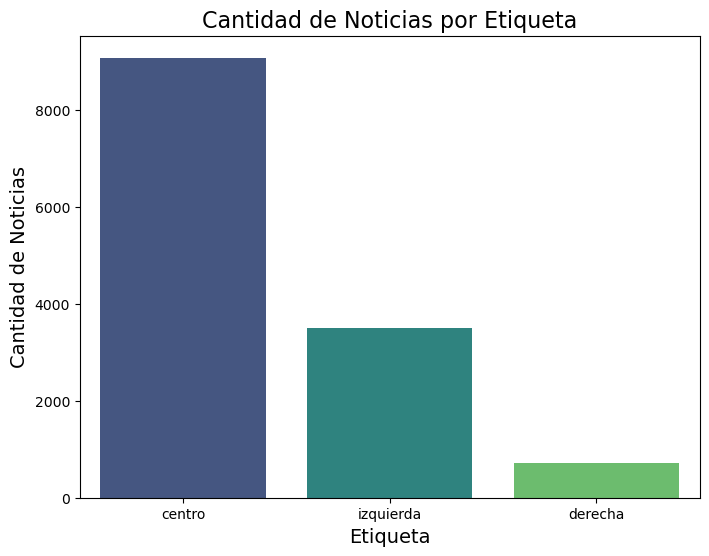

In [65]:
X_nuevas = vectorizer.transform(df['texto_limpio']).toarray()
df['prediccion_ideologia'] = modelo.predict(X_nuevas)

print(df[['titulo', 'prediccion_ideologia']].head(10))


#-----------------------------------------------------------------

# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df['prediccion_ideologia'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')

# Títulos y etiquetas
plt.title('Cantidad de Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)

# Mostrar el gráfico
plt.show()


### K - MEANS

In [78]:
# vectorizamos ahora para k-means
# Entrenamos el vectorizador SOLO con los datos etiquetados
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['texto_limpio'])  # OK

k = 2  # para izquierda, centro, derecha
model = KMeans(n_clusters=k, random_state=42)
df['cluster'] = model.fit_predict(X)

print(df[['texto', 'cluster']].head())



                                               texto  cluster
0   El arranque de un nuevo año suele verse empañ...        1
1   Uno de los cobros que siguen atados a la infl...        1
2  A dos días de terminar el año pasado, el Gobie...        1
3   Mientras el Gobierno Nacional señala que el a...        1
4   Con la expedición del Decreto 2271 de 2023, e...        1


#### EVALUACION

In [79]:
score = silhouette_score(X, df['cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.006


#### VISUALIZACION

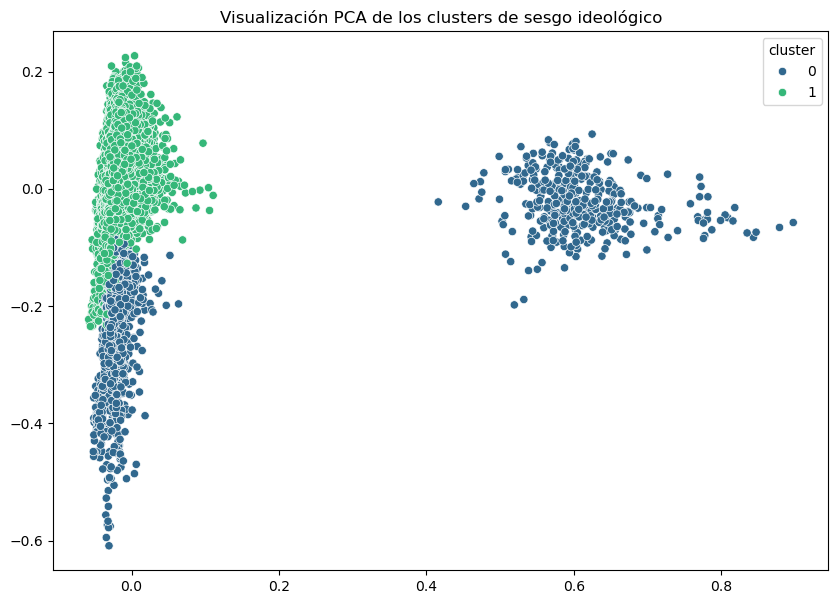

In [80]:
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=df['cluster'], palette="viridis")
plt.title("Visualización PCA de los clusters de sesgo ideológico")
plt.show()


#### KEY - WORDS

In [81]:
def top_terms_per_cluster(tfidf, labels, vectorizer, n=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    for i in range(k):
        print(f"Cluster {i}:")
        print(", ".join([terms[ind] for ind in order_centroids[i, :n]]))
        print()

top_terms_per_cluster(X, df['cluster'], vectorizer)


Cluster 0:
visitar sitio, visitar, sitio, analitik, valora analitik, valora, información, financiera bursátil, bursátil visitar, suministro información

Cluster 1:
petro, colombia, presidente, gobierno, país, gustavo, nacional, gustavo petro, años, año



In [82]:
# Mapea manualmente los clusters a ideologías
cluster_map = {
    0: "derecha",    # <- ajusta esto según tu análisis
    1: "centro",
    2: "izquierda"
}

df['ideologia'] = df['cluster'].map(cluster_map)


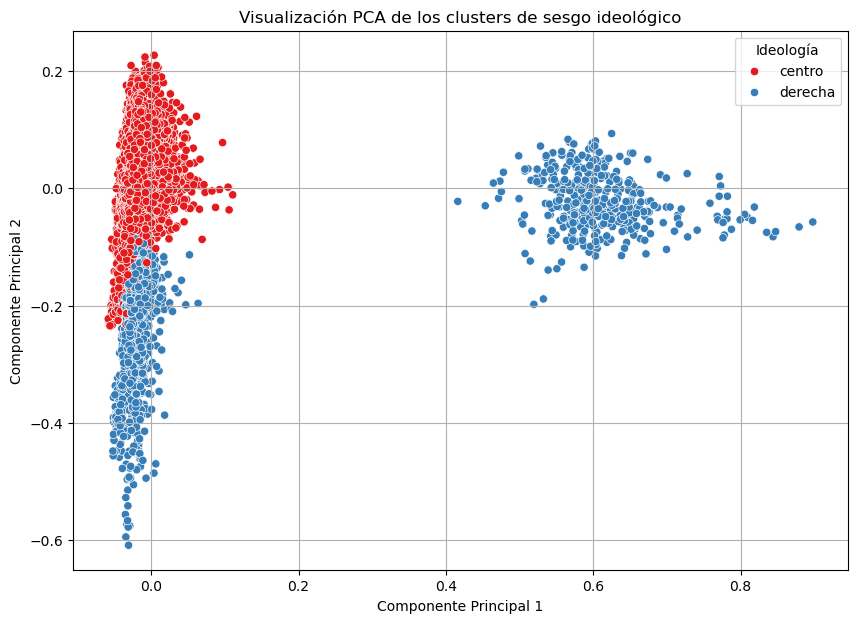

In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=components[:, 0], 
    y=components[:, 1], 
    hue=df['ideologia'],  # usamos las etiquetas
    palette="Set1"
)
plt.title("Visualización PCA de los clusters de sesgo ideológico")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Ideología")
plt.grid(True)
plt.show()
